In [2]:
import robot_plotter as rp
import models_functions as mf
import traj
import numpy as np
import matplotlib.pyplot as plt
import robot_sim as sim

## Script for running many simulations of a particular trajectory
Run many simulations with set random seeds, for use with ANEES purposes. 

This one is for Luft et al's implementation of the CL algorithm

In [3]:
# generate reference trajectory
dt = 0.01
xa1 = np.zeros((mf.STATE_LEN, 1)); xa1[:6] = np.array([[-1.57],[0],[0.5],[5],[0.1],[-0.1]])
xb1 = np.zeros((mf.STATE_LEN, 1)); xb1[:6] = np.array([[0],[0],[6],[6.5],[0.2],[0]])
xc1 = np.zeros((mf.STATE_LEN, 1)); xc1[:6] = np.array([[-1.57],[0],[9.5],[4],[0],[-0.1]])

pos1, y_IMU1_base = traj.gen_poly_traj_multi(pos=[xa1, xb1, xc1], time=[0, 30, 60], dt=dt)

xa2 = np.zeros((mf.STATE_LEN, 1)); xa2[:6] = np.array([[0],[0],[0.5],[3],[0.1],[0]])
xb2 = np.zeros((mf.STATE_LEN, 1)); xb2[:6] = np.array([[3.14],[0],[7],[5],[-0.5],[0]])
xc2 = np.zeros((mf.STATE_LEN, 1)); xc2[:6] = np.array([[-1.57],[0],[3],[0.5],[0],[-0.1]])

pos2, y_IMU2_base = traj.gen_poly_traj_multi(pos=[xa2, xb2, xc2], time=[0, 30, 60], dt=dt)

xa3 = np.zeros((mf.STATE_LEN, 1)); xa3[:6] = np.array([[1.57],[0],[0.5],[0.5],[0],[0.1]])
xb3 = np.zeros((mf.STATE_LEN, 1)); xb3[:6] = np.array([[0],[0],[6],[2],[0],[-0.1]])
xc3 = np.zeros((mf.STATE_LEN, 1)); xc3[:6] = np.array([[-1.57],[0],[9],[3],[0],[0.1]])

pos3, y_IMU3_base = traj.gen_poly_traj_multi(pos=[xa3, xb3, xc3], time=[0, 30, 60], dt=dt)

pos_len = pos1.shape[1] # Assumes that all paths have the same length

# Generate anchors position:
xanc1 = np.zeros((mf.STATE_LEN, 1)); xanc1[:4] = np.array([[-0.7854],[0],[0.1],[6.9]])
xanc2 = np.zeros((mf.STATE_LEN, 1)); xanc2[:4] = np.array([[2.3562],[0],[9.9],[0.1]])

In [4]:
R_b = 0.0009
R_r = 0.001
R_w = 0.0002
R_a = 0.004

Q=np.diag([0.1, 8.0, 8.0, 0.000001, 0.00001, 0.00001])
R=np.diag([R_b, R_r, R_w, R_a, R_a]) # approx vaules from datasheets
P=np.diag([0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0004,0.01,0.01]) # Initialize with system noise for bias

anchor1 = sim.Anchor(x0=xanc1)
anchor2 = sim.Anchor(x0=xanc2)


In [ ]:
list_seeds = [1061]
#1061, 1, 19001, 7871871, 2289
seeds_num = len(list_seeds)
x_logL1 = np.zeros((mf.STATE_LEN, pos_len, seeds_num))
P_logL1 = np.zeros((mf.STATE_LEN, mf.STATE_LEN, pos_len, seeds_num))
x_logL2 = np.zeros((mf.STATE_LEN, pos_len, seeds_num))
P_logL2 = np.zeros((mf.STATE_LEN, mf.STATE_LEN, pos_len, seeds_num))
x_logL3 = np.zeros((mf.STATE_LEN, pos_len, seeds_num))
P_logL3 = np.zeros((mf.STATE_LEN, mf.STATE_LEN, pos_len, seeds_num))

for j in range(len(list_seeds)):
    print("seed: " + str(list_seeds[j]))
    bias_vec = np.array([[0.00],[0.0],[0.0]])
    timu1 = y_IMU1_base.copy()
    timu2 = y_IMU2_base.copy()
    timu3 = y_IMU3_base.copy()

    np.random.seed(list_seeds[j])
    y_IMU1 = traj.gen_noise(timu1, dt=1, sigma=np.diag([R_w, R_a, R_a]), bias=bias_vec)
    y_IMU2 = traj.gen_noise(timu2, dt=1, sigma=np.diag([R_w, R_a, R_a]), bias=bias_vec)
    y_IMU3 = traj.gen_noise(timu3, dt=1, sigma=np.diag([R_w, R_a, R_a]), bias=bias_vec)

    # Run LUFT algorithm
    robotL1 = sim.robot_luft(x0=xa1, path=pos1, imu=y_IMU1, dt=dt, Q=Q, R=R, P=P, id=111)
    robotL2 = sim.robot_luft(x0=xa2, path=pos2, imu=y_IMU2, dt=dt, Q=Q, R=R, P=P, id=222)
    robotL3 = sim.robot_luft(x0=xa3, path=pos3, imu=y_IMU3, dt=dt, Q=Q, R=R, P=P, id=333)

    for i in range(pos_len-1):
        robotL1.predict(imu_correct=True)
        robotL2.predict(imu_correct=True)
        robotL3.predict(imu_correct=True)
        if (i > 0 and i % 100 == 0):
            print(i)
            robotL1.anchor_meas(anchor1, sr=R_r, sb=R_b)            
            robotL1.anchor_meas(anchor2, sr=R_r, sb=R_b)

            robotL1.robot_meas_luft(robotL2, sr=R_r, sb=R_b)
            robotL2.robot_meas_luft(robotL1, sr=R_r, sb=R_b)

            robotL3.robot_meas_luft(robotL2, sr=R_r, sb=R_b)
            robotL2.robot_meas_luft(robotL3, sr=R_r, sb=R_b)
    
    # Save estimates and covariances:
    x_logL1[:,:,j] = robotL1.x_log
    P_logL1[:,:,:,j] = robotL1.P_log
    x_logL2[:,:,j] = robotL2.x_log
    P_logL2[:,:,:,j] = robotL2.P_log
    x_logL3[:,:,j] = robotL3.x_log
    P_logL3[:,:,:,j] = robotL3.P_log


seed: 1061
100
Adding new robot: 111
Adding new robot: 222
Adding new robot: 333
Adding new robot: 222
200
300
Wrong measurement used!! Bearing: 1.5420725759432417 was used instead of: 1.5995200776465515
400
500
Wrong measurement used!! Bearing: 1.569531081076908 was used instead of: 1.572061572512885
600
Wrong measurement used!! Bearing: 1.5719952058147058 was used instead of: 1.5695974477750874
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
Wrong measurement used!! Bearing: 4.746766688146125 was used instead of: -1.605174034556332
5100
5200
5300
5400
Wrong measurement used!! Bearing: 1.6057672412364976 was used instead of: 1.5358254123532955
5500
5600
Wrong measurement used!! Bearing: 1.5156660456883344 was used instead of: 1.6259266079014587
5700
5800
5900


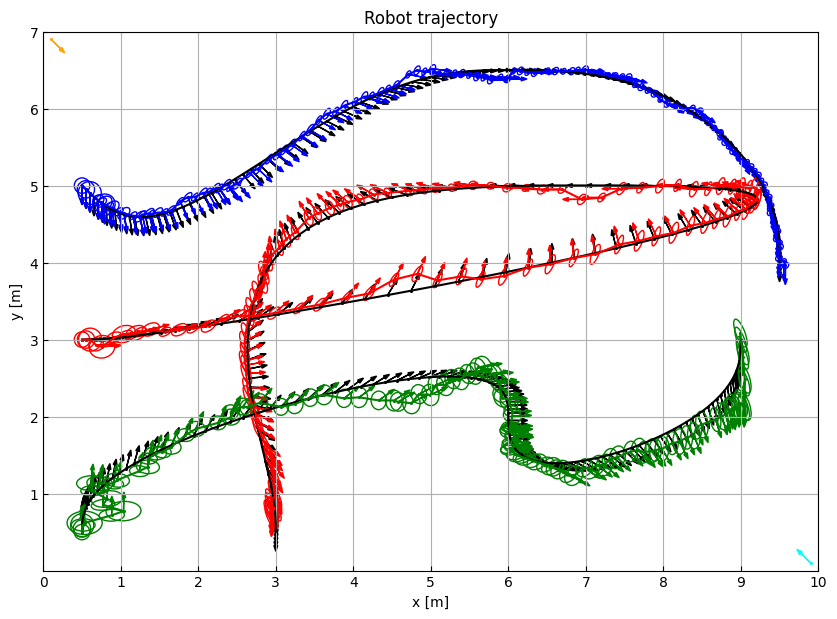

In [16]:
# Plot the choosen simulation:
s_idx = 0

# Plot ground truth
fig, ax = rp.setup_plot()
rp.plot_position(ax, pos1[:,::50], color='black')
rp.plot_position(ax, pos2[:,::50], color='black')
rp.plot_position(ax, pos3[:,::50], color='black')

# Plot states of robots:
rp.plot_position2(ax, x_logL1[:,::50,s_idx], P_logL1[:,:,::50,s_idx], color='blue')
rp.plot_position2(ax, x_logL2[:,::50,s_idx], P_logL2[:,:,::50,s_idx], color='red')
rp.plot_position2(ax, x_logL3[:,::50,s_idx], P_logL3[:,:,::50,s_idx], color='green')

anchor1.draw_position(ax, color='orange')
anchor2.draw_position(ax, color='cyan')

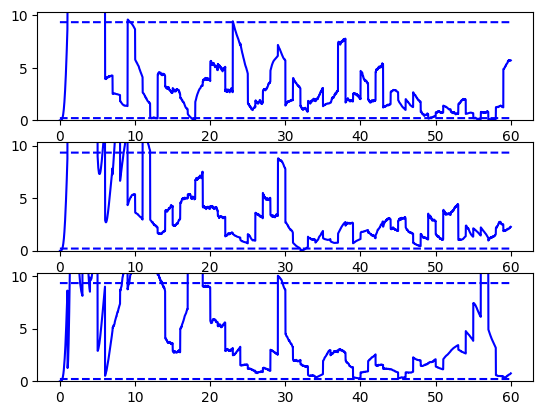

In [6]:
# Plot metrics:
# ANEES analysis
# If higher than confidence interval, then the estimate is overconfident
fig, axs2 = plt.subplots(3)
anees_sel = np.array([[True],[False],[False]])
pos_ind = [0, 2, 3]
rp.plot_ANEES(axs2[0], 
             x_est=x_logL1[pos_ind,:],
             x_true=robotL1.path[:3,:], 
             P=P_logL1[np.ix_(pos_ind, pos_ind)], 
             rad_sel=anees_sel,
             dt=dt,
             prob=0.95)
rp.plot_ANEES(axs2[1], 
             x_est=x_logL2[pos_ind,:],
             x_true=robotL2.path[:3,:], 
             P=P_logL2[np.ix_(pos_ind, pos_ind)], 
             rad_sel=anees_sel,
             dt=dt,
             prob=0.95)
rp.plot_ANEES(axs2[2], 
             x_est=x_logL3[pos_ind,:],
             x_true=robotL3.path[:3,:], 
             P=P_logL3[np.ix_(pos_ind, pos_ind)], 
             rad_sel=anees_sel,
             dt=dt,
             prob=0.95)

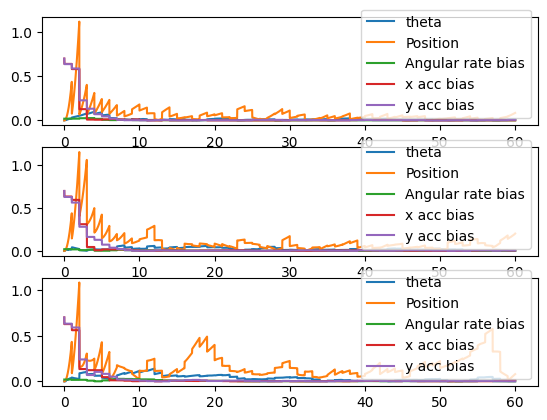

In [7]:
# Plot RMSE errors:
fig, axs3 = plt.subplots(3)

rp.plot_RMSE(axs3[0], x_logL1, robotL1.path, biases=bias_vec, dt=dt)
rp.plot_RMSE(axs3[1], x_logL2, robotL2.path, biases=bias_vec, dt=dt)
rp.plot_RMSE(axs3[2], x_logL3, robotL3.path, biases=bias_vec, dt=dt)